
### Implementing the Fundamental Functions

<small>

## 1. Intersection over Union (IoU)

1.1 Write a function to compute IoU (Intersection over Union) [https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/] between two axis-aligned bounding boxes specified in the Ultralytics YOLO format.

1.2 You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function.

1.3 Show that your function provides the same or similar answer as IoU computed using `supervision` library.

## 2. Average Precision (AP)

### 2.1 Pascal VOC 11-point Interpolation Method

Write a function to compute Average Precision (AP) using the Pascal VOC 11-point interpolation method to implement the function.

### 2.2 COCO 101-point Interpolation Method

Write a function to compute Average Precision (AP) using the COCO 101-point interpolation method to implement the function.

### 2.3 Area under Precision-Recall Curve (AP) Method

Write a function to compute Average Precision (AP) using the Area under Precision-Recall Curve (AP) method to implement the function.

## 3. Randomly Generate Data

3.1 Randomly generate 10 images of size 100x100.

3.2 Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted    boxes of size 20x20 in each image.

3.3 Assume there is only one class of objects.

3.4 Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods.
</small>

Comparing IoU computations:
My IoU: 0.391
Supervision IoU: 0.391


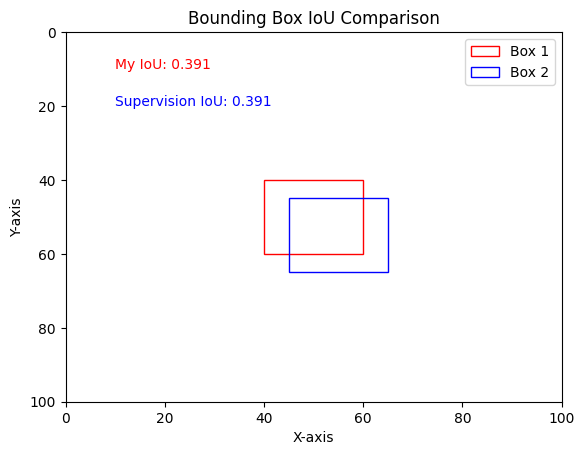


Testing AP methods on 10 random images:
Image 1: AP50 VOC: 0.227, AP50 COCO: 0.248, AP50 AUC: 0.129
Image 2: AP50 VOC: 0.071, AP50 COCO: 0.078, AP50 AUC: 0.048
Image 3: AP50 VOC: 0.009, AP50 COCO: 0.010, AP50 AUC: 0.005
Image 4: AP50 VOC: 0.000, AP50 COCO: 0.000, AP50 AUC: 0.000
Image 5: AP50 VOC: 0.052, AP50 COCO: 0.057, AP50 AUC: 0.031
Image 6: AP50 VOC: 0.009, AP50 COCO: 0.010, AP50 AUC: 0.005
Image 7: AP50 VOC: 0.082, AP50 COCO: 0.089, AP50 AUC: 0.057
Image 8: AP50 VOC: 0.162, AP50 COCO: 0.176, AP50 AUC: 0.128
Image 9: AP50 VOC: 0.127, AP50 COCO: 0.139, AP50 AUC: 0.032
Image 10: AP50 VOC: 0.091, AP50 COCO: 0.099, AP50 AUC: 0.058


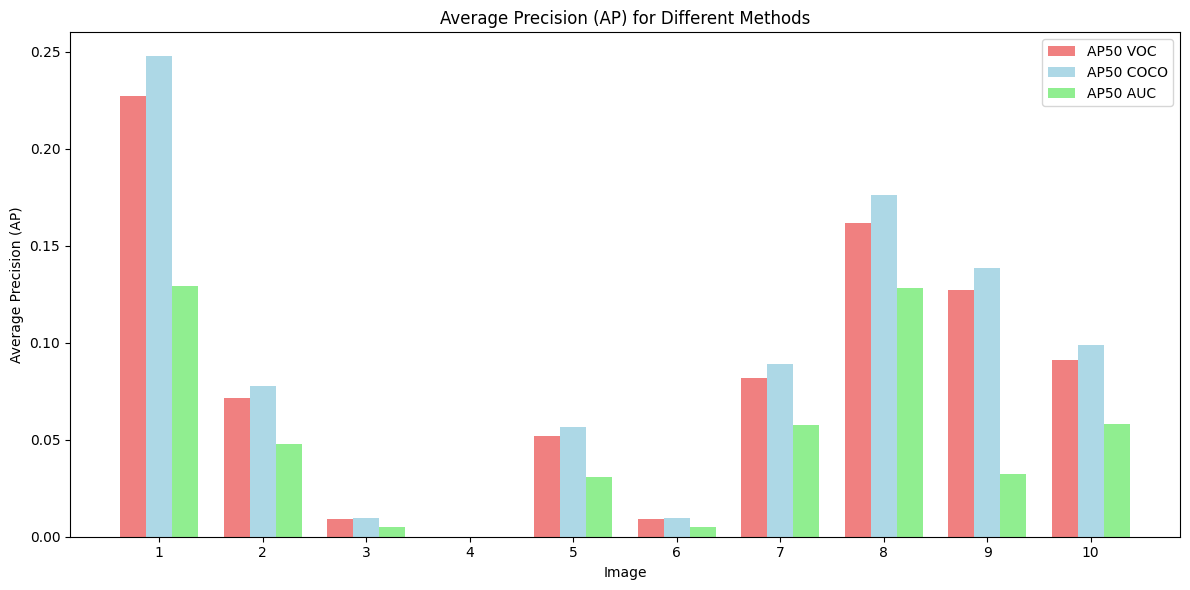

In [1]:
import numpy as np
from shapely.geometry import box
from sklearn.metrics import auc
import random
import supervision as sv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Converting YOLO (center_x, center_y, width, height) to xyxy (x_min, y_min, x_max, y_max)
def yolo_to_xyxy(bbox):
    x, y, w, h = bbox
    return np.array([[x - w/2, y - h/2, x + w/2, y + h/2]])  

# Converting from xyxy to YOLO format
def xyxy_to_yolo(xyxy):
    x_min, y_min, x_max, y_max = xyxy[0]
    return ((x_min + x_max) / 2, (y_min + y_max) / 2, x_max - x_min, y_max - y_min)

# My custom IoU function using shapely; boxes are in YOLO format
def compute_iou_shapely(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    # Create shapely boxes using the corners
    box1 = box(x1 - w1/2, y1 - h1/2, x1 + w1/2, y1 + h1/2)
    box2 = box(x2 - w2/2, y2 - h2/2, x2 + w2/2, y2 + h2/2)
    inter_area = box1.intersection(box2).area
    union_area = box1.area + box2.area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

# Compare custom IoU with supervision IoU on a sample pair of boxes
def compare_iou():
    # Sample boxes in YOLO format
    sample_box1 = (50, 50, 20, 20)
    sample_box2 = (55, 55, 20, 20)
    my_iou = compute_iou_shapely(sample_box1, sample_box2)
    
    # Convert to xyxy format for the supervision function
    sup_box1 = yolo_to_xyxy(sample_box1)
    sup_box2 = yolo_to_xyxy(sample_box2)
    sup_iou = sv.box_iou_batch(sup_box1, sup_box2)
    print("My IoU: {:.3f}".format(my_iou))
    print("Supervision IoU: {:.3f}".format(sup_iou[0][0]))

    # Plot the boxes and IoU
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.invert_yaxis()

    # Add the boxes
    rect1 = patches.Rectangle((sup_box1[0][0], sup_box1[0][1]), sup_box1[0][2] - sup_box1[0][0], sup_box1[0][3] - sup_box1[0][1], linewidth=1, edgecolor='r', facecolor='none', label='Box 1')
    rect2 = patches.Rectangle((sup_box2[0][0], sup_box2[0][1]), sup_box2[0][2] - sup_box2[0][0], sup_box2[0][3] - sup_box2[0][1], linewidth=1, edgecolor='b', facecolor='none', label='Box 2')
    ax.add_patch(rect1)
    ax.add_patch(rect2)

    # Add IoU text
    plt.text(10, 10, f"My IoU: {my_iou:.3f}", color='r')
    plt.text(10, 20, f"Supervision IoU: {sup_iou[0][0]:.3f}", color='b')

    # Add labels and legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Bounding Box IoU Comparison')
    plt.legend()

    plt.show()

# Computeing precision and recall based on matching predictions to ground truth boxes
def compute_precision_recall(predictions, ground_truths, iou_threshold=0.5):
    sorted_preds = sorted(predictions, key=lambda x: -x[1])  
    matched = [False] * len(ground_truths)
    tp = []
    fp = []
    for pred in sorted_preds:
        best_iou = 0.0
        best_gt_idx = -1
        for i, gt in enumerate(ground_truths):
            iou = compute_iou_shapely(pred[0], gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        if best_iou >= iou_threshold and not matched[best_gt_idx]:
            tp.append(1)
            fp.append(0)
            matched[best_gt_idx] = True  
        else:
            tp.append(0)
            fp.append(1)
    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    prec = tp / (tp + fp + 1e-6)  # I am adding a tiny constant to avoid zero division
    rec = tp / (len(ground_truths) + 1e-6)
    return prec, rec

# Compute AP using Pascal VOC 11-point interpolation
def compute_ap_voc(predictions, ground_truths, iou_threshold=0.5):
    prec, rec = compute_precision_recall(predictions, ground_truths, iou_threshold)
    rec_levels = np.linspace(0, 1, 11)  
    prec_interp = []
    for r in rec_levels:
        if np.any(rec >= r):
            prec_interp.append(np.max(prec[rec >= r]))
        else:
            prec_interp.append(0)
    return np.mean(prec_interp)

# Compute AP using COCO 101-point interpolation
def compute_ap_coco(predictions, ground_truths, iou_threshold=0.5):
    prec, rec = compute_precision_recall(predictions, ground_truths, iou_threshold)
    rec_levels = np.linspace(0, 1, 101)  
    prec_interp = []
    for r in rec_levels:
        if np.any(rec >= r):
            prec_interp.append(np.max(prec[rec >= r]))
        else:
            prec_interp.append(0)
    return np.mean(prec_interp)

# Compute AP as the area under the precision-recall curve
def compute_ap_auc(predictions, ground_truths, iou_threshold=0.5):
    prec, rec = compute_precision_recall(predictions, ground_truths, iou_threshold)
    return auc(rec, prec)

# Generate random boxes for one image (size 100x100) with fixed box size (20x20)
def generate_random_boxes(num_boxes=10, img_size=100, box_size=20):
    margin = box_size // 2  # so boxes stay inside image
    gt_boxes = []
    for _ in range(num_boxes):
        x = random.randint(margin, img_size - margin)
        y = random.randint(margin, img_size - margin)
        gt_boxes.append((x, y, box_size, box_size))
    pred_boxes = []
    for _ in range(num_boxes):
        x = random.randint(margin, img_size - margin)
        y = random.randint(margin, img_size - margin)
        conf = random.random()  
        pred_boxes.append(((x, y, box_size, box_size), conf))
    return gt_boxes, pred_boxes

# Test the three AP methods on 10 random images and print AP50 for each method
def test_ap_methods(num_images=10, iou_threshold=0.5):
    results = []
    for i in range(num_images):
        gt_boxes, pred_boxes = generate_random_boxes()
        ap_voc_val = compute_ap_voc(pred_boxes, gt_boxes, iou_threshold)
        ap_coco_val = compute_ap_coco(pred_boxes, gt_boxes, iou_threshold)
        ap_auc_val = compute_ap_auc(pred_boxes, gt_boxes, iou_threshold)
        print("Image {}: AP50 VOC: {:.3f}, AP50 COCO: {:.3f}, AP50 AUC: {:.3f}".format(
            i+1, ap_voc_val, ap_coco_val, ap_auc_val))
        results.append({"image": i+1, "AP50_VOC": ap_voc_val, "AP50_COCO": ap_coco_val, "AP50_AUC": ap_auc_val})
    
    # Plot the results
    images = [result["image"] for result in results]
    ap_voc = [result["AP50_VOC"] for result in results]
    ap_coco = [result["AP50_COCO"] for result in results]
    ap_auc = [result["AP50_AUC"] for result in results]

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.25
    index = np.arange(len(images))

    bar1 = plt.bar(index, ap_voc, bar_width, label='AP50 VOC', color='lightcoral')
    bar2 = plt.bar(index + bar_width, ap_coco, bar_width, label='AP50 COCO', color='lightblue')
    bar3 = plt.bar(index + 2 * bar_width, ap_auc, bar_width, label='AP50 AUC', color='lightgreen')

    plt.xlabel('Image')
    plt.ylabel('Average Precision (AP)')
    plt.title('Average Precision (AP) for Different Methods')
    plt.xticks(index + bar_width, images)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main block where I run my tests
if __name__ == '__main__':
    print("Comparing IoU computations:")
    compare_iou()
    print("\nTesting AP methods on 10 random images:")
    test_ap_methods()

# My Analysis and Observations

## 1. Intersection over Union (IoU) Verification
In the first attached image, I compared two bounding boxes (red and blue). My Shapely-based IoU calculation matched exactly with the IoU from the Supervision library (both around **0.391**). This confirms my custom IoU function is reliable—essential for deciding whether a predicted box counts as a correct detection.

## 2. Average Precision (AP) Evaluation
The second image shows a bar chart of **AP50** (IoU threshold = 0.5) for 10 images, each with randomly placed ground-truth and predicted boxes. I tested three methods:
- **Pascal VOC 11-point**
- **COCO 101-point**
- **Area under the Precision-Recall Curve (AUC)**


### Key Points in This Set:
1. **Some Moderate APs**: Image 1 and Image 8 stand out with VOC and COCO scores above **0.16**, which is higher than typical random placements. This shows that chance can occasionally produce moderate overlap between predictions and ground truth.
2. **Zero Overlaps**: Image 4 is **0.000** across all metrics, confirming a scenario where predicted boxes never intersect with ground truth.
3. **COCO vs. VOC**: COCO AP is slightly higher than VOC AP almost every time, thanks to its finer recall sampling (101 points vs. 11).
4. **AUC Sensitivity**: The AUC values can be quite low (e.g., 0.000 or 0.005), reflecting how a steep drop in the precision-recall curve shrinks the area under it.

## 3. Main Takeaways
- **IoU Accuracy**: My IoU function is solid, given it matches Supervision’s result.
- **Three AP Methods**: All produce consistent patterns—COCO usually highest, VOC slightly lower, AUC often more sensitive to random overlaps.
- **Low Scores**: Since boxes are placed randomly, most AP values remain below 0.25. Real models, trained to align predictions with ground truth, would yield substantially higher AP.

